# Land Use / Land Cover Segmentation Using Sentinel-2 and Random Forest

This workflow demonstrates how to use [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery for segmenting land use / land cover (LULC) using a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier. We will pursue this objective by integrating ground truth forest areas from the **National Forest Classification Dataset (LULC)** from 2018. To make this scalable to all of Vanuatu, we use an [administrative boundaries dataset from Pacific data hub](https://pacificdata.org/data/dataset/2016_vut_phc_admin_boundaries/resource/66ae054b-9b67-4876-b59c-0b078c31e800).

In this notebook, we will demonstrate the following:

1. **Data Acquisition**:
   - We use **Sentinel-2 L2A** data (Level-2A provides surface reflectance) accessed via the [AWS STAC catalog](https://registry.opendata.aws/). The search is filtered by parameters like a region of interest (AOI), time range, and cloud cover percentage to obtain suitable imagery.
   
2. **Preprocessing**:
   - The Sentinel-2 imagery contains several spectral bands (e.g., Red, Green, Blue, and Near-Infrared). These are extracted and combined into a single dataset for analysis. Additionally, the imagery is masked to remove areas outside the AOI and focus on the relevant pixels.
  
3. **Feature Extraction**:
   - Features for the classifier are extracted from the Sentinel-2 spectral bands. Here, we will use the reflectance values from the Red, Green, Blue, and Near-Infrared (NIR) bands. We will mask out clouds from these bands before further analysis.

4. **Ground Truth Data Integration**:
   - A shapefile containing polygons attributed by land cover/land use is loaded into a [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). This allows us to create multi-class labels for the pixels in the Sentinel-2 imagery.
  
5. **Data Splitting**:
   - To ensure correct model training, we split the features and labels into training (80%) and testing (20%) sets. A 'seed' value is used for the random number generator to ensure this random split is reproducible.

6. **Random Forest Classification**:
   - We train a **Random Forest** classifier to predict planted forest areas. The `n_estimators` parameter is a key hyperparameter, determining the number of decision trees in the forest. Random Forest leverages the collective wisdom of multiple decision trees to make accurate predictions.

7. **Prediction**:
   - We will use the trained classifier to predict the likelihood of lulc types for each pixel in the image. 

8. **Evaluation**:
   - After making predictions on the test set, we evaluate the model's performance using metrics such as accuracy and F1-score. This allows us to assess the performance of the Random Forest model and the effectiveness of the selected features.

9. **Visualization**:
   - We visualize the predictions by plotting the classified map, where lulc types are indicated by specific color codes.

At the end, you will have trained a model to predict land use + land cover in Vanuatu.

![result](https://github.com/user-attachments/assets/6794df2b-45b4-4c6a-923b-98b33e305a39)

In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 120.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 84.5 MB/s eta 0:00:0000:0100:01


In [2]:
import dask.dataframe as dd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import odc.stac
import rasterio.features
from shapely.geometry import box
import xarray as xr
import xgboost as xgb
from dask import delayed, compute
from geocube.api.core import make_geocube
from pystac_client import Client
from shapely.geometry import Polygon, shape
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
#from sklearn.model_selection import train_test_split
from dask_ml.model_selection import train_test_split

## Data Acquisition

Let's read the LULC data into a GeoDataFrame. 

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) is a type of data structure used to store geographic data in Python, provided by the [GeoPandas](https://geopandas.org/en/stable/) library. It extends the functionality of a pandas DataFrame to handle spatial data, enabling geospatial analysis and visualization. Like a pandas DataFrame, a GeoDataFrame is a tabular data structure with labeled axes (rows and columns), but it adds special features to work with geometric objects, such as:
- a geometry column
- a CRS
- accessibility to spatial operations (e.g.  intersection, union, buffering, and spatial joins)

In [3]:
lulc_gdf = gpd.read_file("./lulc_utm.geojson")

In [4]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_pid_4326.geojson")

In [5]:
admin_boundaries_gdf.head(2)

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."


In [5]:
len(lulc_gdf), len(admin_boundaries_gdf)

(194764, 6)

We can check out the attributes associated with this dataset:

In [8]:
lulc_gdf.columns

Index(['fid', 'is_name', 'lulc_2008', 'lulc_2018', 'area_ha', 'geometry'], dtype='object')

Let's see which classes are available to us in the most recent LULC column.

In [9]:
lulc_gdf.lulc_2018.unique()

array(['Bareland', 'Coconut Plantation', 'Dense Forest', 'Grassland',
       'Open Forest', 'Settlement', 'Water', None, 'Agriculture', 'Cloud',
       'other', 'Shrubs', 'Plantation Forest', 'Mangroves'], dtype=object)

And view a subset of the data (shuffled for more variety in the 10 samples):

In [10]:
lulc_gdf.sample(frac=1).head(10)

,fid,is_name,lulc_2008,lulc_2018,area_ha,geometry
10773,10774.0,Ambrym,None,Shrubs,0.005057,"MULTIPOLYGON (((841003.26 8211314.842, 840993...."
170159,170160.0,Loh,None,Dense Forest,0.002260,"MULTIPOLYGON (((676977.978 8525612.5, 676972.5..."
147126,147127.0,Efate,Shrubs,Grassland,0.000939,"MULTIPOLYGON (((851681.856 8043887.5, 851677.5..."
99152,99153.0,Gaua,None,Dense Forest,0.001640,"MULTIPOLYGON (((777537.939 8417702.5, 777532.5..."
161020,161021.0,Tanna,None,Open Forest,1.890200,"MULTIPOLYGON (((949092.991 7855841.383, 949117..."
30541,30542.0,Erromango,None,Dense Forest,0.031659,"MULTIPOLYGON (((938905.125 7905453.096, 938900..."
46335,46336.0,Espiritu Santo,None,Coconut Plantation,0.011965,"MULTIPOLYGON (((680073.87 8310987.232, 680062...."
167355,167356.0,Aoba (omba),None,Grassland,0.957664,"MULTIPOLYGON (((815393.836 8307349.607, 815372..."
185491,185492.0,Ambrym,None,Dense Forest,0.008774,"MULTIPOLYGON (((828088.043 8206513.754, 828074..."
108815,108816.0,Malekula,None,Dense Forest,6.114290,"MULTIPOLYGON (((776250.579 8178623.702, 776249..."


We can also plot the vector dataset, and color code the polygons by the relevant LULC column.

<Axes: >

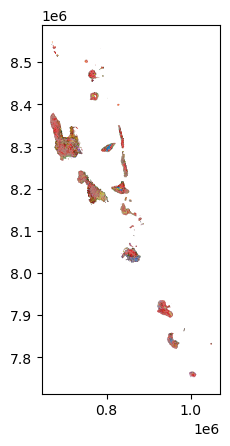

In [11]:
lulc_gdf.plot(column='lulc_2018')

Break down the LULC into subsets per admin boundary.

In [11]:
# Ensure both GeoDataFrames have the same CRS
if lulc_gdf.crs != admin_boundaries_gdf.crs:
    admin_boundaries_gdf = admin_boundaries_gdf.to_crs(lulc_gdf.crs)

clipped_gdfs = []

# Clip polygons by each boundary and save as separate GeoDataFrame
i = 0
for _, boundary in admin_boundaries_gdf.iterrows():
    boundary_geom = boundary.geometry
    clipped = gpd.clip(lulc_gdf, boundary_geom)
    if not clipped.empty:
        clipped["admin_boundary_id"] = boundary["pid"]  # Assign an ID or attribute from the admin boundary
        clipped_gdfs.append(clipped)
        i = i+1

print(i)

# Combine into a dictionary with admin boundary ID as the key
result = {
    row["pid"]: gdf
    for (_, row), gdf in zip(admin_boundaries_gdf.iterrows(), clipped_gdfs)
}

# Save each clipped GeoDataFrame
for admin_id, gdf in result.items():
    gdf.to_file(f"clipped_polygons_{admin_id}.geojson", driver="GeoJSON")
    

6


Create raster image and label xarray datarrays for each admin boundary.

In [23]:
admin_boundaries_gdf

,pid,geometry
pname,,
TORBA,1,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
SANMA,2,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
PENAMA,3,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
MALAMPA,4,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
SHEFA,5,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
TAFEA,6,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [6]:
YEAR = 2018
PROVINCE_TRAIN = "SHEFA"
PROVINCE_TEST = "TORBA"

In [7]:
admin_boundaries_gdf = admin_boundaries_gdf.set_index(keys="pname")  # set province name as the index

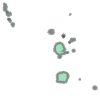

In [8]:
GEOM_TRAIN = admin_boundaries_gdf.loc[PROVINCE_TRAIN].geometry
GEOM_TRAIN

GEOM_TEST = admin_boundaries_gdf.loc[PROVINCE_TEST].geometry
GEOM_TEST

In [9]:
STAC_URL = "http://stac.digitalearthpacific.org/"
stac_client = Client.open(STAC_URL)

In [10]:
geos = glob.glob("clipped_lulc/*.geojson")
gdf_train = gpd.read_file(geos[4])

s2_search = stac_client.search(
    collections=["dep_s2_geomad"], # Sentinel-2 Geometric Median and Absolute Deviations (GeoMAD) over the Pacific.
    intersects=GEOM_TRAIN, 
    datetime=str(YEAR),
)
# Retrieve all items from search results
s2_items = s2_search.item_collection()
print("len(s2_items): ", len(s2_items))

s2_data_train = odc.stac.load(
    items=s2_items,
    bands=["blue", "green", "red", "nir08", "swir16"],
    chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
    resolution=20,
)
print("s2_data: ", s2_data_train)

len(s2_items):  3
s2_data:  <xarray.Dataset> Size: 691MB
Dimensions:      (y: 14400, x: 4800, time: 1)
Coordinates:
  * y            (y) float64 115kB -1.792e+06 -1.792e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 38kB 1.992e+06 1.992e+06 ... 2.088e+06 2.088e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2018-01-01
Data variables:
    blue         (time, y, x) uint16 138MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 138MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 138MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 138MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) uint16 138MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>


In [11]:
gdf_test = gpd.read_file(geos[0])

s2_search = stac_client.search(
    collections=["dep_s2_geomad"], # Sentinel-2 Geometric Median and Absolute Deviations (GeoMAD) over the Pacific.
    intersects=GEOM_TEST, 
    datetime=str(YEAR),
)
# Retrieve all items from search results
s2_items = s2_search.item_collection()
print("len(s2_items): ", len(s2_items))

s2_data_test = odc.stac.load(
    items=s2_items,
    bands=["blue", "green", "red", "nir08", "swir16"],
    chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
    resolution=20,
)
print("s2_data: ", s2_data_test)

len(s2_items):  5
s2_data:  <xarray.Dataset> Size: 2GB
Dimensions:      (y: 14400, x: 14400, time: 1)
Coordinates:
  * y            (y) float64 115kB -1.408e+06 -1.408e+06 ... -1.696e+06
  * x            (x) float64 115kB 1.8e+06 1.8e+06 ... 2.088e+06 2.088e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2018-01-01
Data variables:
    blue         (time, y, x) uint16 415MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 415MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 415MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 415MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) uint16 415MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>


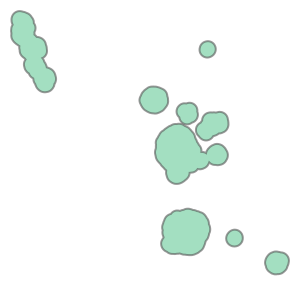

In [12]:
# Keep projection aligned with raster
raster_crs = s2_data_train.rio.crs

# Get only the select province and reproject
gdf_reprojected_train = admin_boundaries_gdf.loc[[PROVINCE_TRAIN]].to_crs(crs=raster_crs)
gdf_reprojected_test = admin_boundaries_gdf.loc[[PROVINCE_TEST]].to_crs(crs=raster_crs)

# Buffer in raster units (meters if UTM)
geom_buffered_train = gdf_reprojected_train.buffer(distance=5000)[PROVINCE_TRAIN]
geom_buffered_test = gdf_reprojected_test.buffer(distance=5000)[PROVINCE_TEST]
geom_buffered_test

In [13]:
# Clip
s2_clipped_train = s2_data_train.rio.clip(geometries=[geom_buffered_train])
s2_clipped_test = s2_data_test.rio.clip(geometries=[geom_buffered_test])


In [14]:
s2_clipped_train


<xarray.Dataset> Size: 270MB
Dimensions:      (y: 7804, x: 3457, time: 1)
Coordinates:
  * y            (y) float64 62kB -1.853e+06 -1.853e+06 ... -2.009e+06
  * x            (x) float64 28kB 2.012e+06 2.012e+06 ... 2.081e+06 2.081e+06
  * time         (time) datetime64[ns] 8B 2018-01-01
    spatial_ref  int64 8B 0
Data variables:
    blue         (time, y, x) uint16 54MB dask.array<chunksize=(1, 19, 31), meta=np.ndarray>
    green        (time, y, x) uint16 54MB dask.array<chunksize=(1, 19, 31), meta=np.ndarray>
    red          (time, y, x) uint16 54MB dask.array<chunksize=(1, 19, 31), meta=np.ndarray>
    nir08        (time, y, x) uint16 54MB dask.array<chunksize=(1, 19, 31), meta=np.ndarray>
    swir16       (time, y, x) uint16 54MB dask.array<chunksize=(1, 19, 31), meta=np.ndarray>

In [15]:
s2_rgb = s2_clipped_train[["red", "green", "blue"]] 
s2_rgb_array = s2_rgb.to_array("band")  # now dims: band, y, x
s2_rgb_array_squeezed = s2_rgb_array.squeeze(dim="time", drop=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


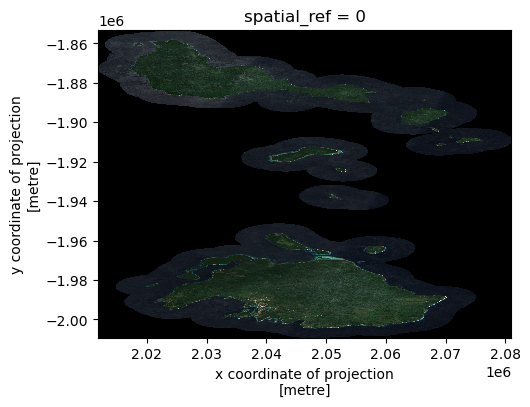

In [16]:
s2_rgb_array_squeezed.plot.imshow(size=4, vmin=0, vmax=4000)

In [17]:
def compute_indices(ds):
    red = ds["red"]
    green = ds["green"]
    blue = ds["blue"]
    nir = ds["nir08"]
    swir = ds["swir16"]
    eps = 1e-6
    return xr.Dataset({
        "NDVI": (nir - red) / (nir + red + eps),
        "MNDWI": (green - swir) / (green + swir + eps),
        "SAVI": ((nir - red) / (nir + red + eps)) * 1.5,
        "BSI": ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + eps),
    })

index_data_train = compute_indices(s2_clipped_train).squeeze("time", drop=True)
index_data_test = compute_indices(s2_clipped_test).squeeze("time", drop=True)
print(index_data_train)

<xarray.Dataset> Size: 863MB
Dimensions:      (y: 7804, x: 3457)
Coordinates:
  * y            (y) float64 62kB -1.853e+06 -1.853e+06 ... -2.009e+06
  * x            (x) float64 28kB 2.012e+06 2.012e+06 ... 2.081e+06 2.081e+06
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (y, x) float64 216MB dask.array<chunksize=(19, 31), meta=np.ndarray>
    MNDWI        (y, x) float64 216MB dask.array<chunksize=(19, 31), meta=np.ndarray>
    SAVI         (y, x) float64 216MB dask.array<chunksize=(19, 31), meta=np.ndarray>
    BSI          (y, x) float64 216MB dask.array<chunksize=(19, 31), meta=np.ndarray>


In [18]:
width_train, height_train = s2_clipped_train.x.size, s2_clipped_train.y.size
width_test, height_test = s2_clipped_test.x.size, s2_clipped_test.y.size
epsg = s2_clipped_train.rio.crs.to_epsg()
bands = ['red', 'green', 'blue', 'nir08']
unique_classes = gdf_train['lulc_2018'].unique()
class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}

# Add numerical column
gdf_train['lulc_2018_numeric'] = gdf_train['lulc_2018'].map(class_mapping)
gdf_test['lulc_2018_numeric'] = gdf_test['lulc_2018'].map(class_mapping)

#print(gdf_.lulc_2018.unique(), gdf_.lulc_2018_numeric.unique())
gdf_train = gdf_train.to_crs(epsg=epsg)
gdf_test = gdf_test.to_crs(epsg=epsg)
# Define the resolution and bounds based on Sentinel-2 features
resolution = s2_clipped_train.rio.resolution()
bounds_train = s2_clipped_train.rio.bounds()
bounds_test = s2_clipped_test.rio.bounds()

gdf_rpg = lulc_gdf.to_crs(s2_clipped_train.rio.crs)

unique_classes = gdf_rpg['lulc_2018'].unique()
class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}

# Add numerical column
gdf_rpg['lulc_2018_numeric'] =  gdf_rpg['lulc_2018'].map(class_mapping)

raster_bounds_train = box(*s2_clipped_train.rio.bounds())
gdf_train_clipped = gdf_rpg[gdf_rpg.intersects(raster_bounds_train)]

raster_bounds_test = box(*s2_clipped_test.rio.bounds())
gdf_test_clipped = gdf_rpg[gdf_rpg.intersects(raster_bounds_test)]

print(f"Before: {len(gdf_rpg)} | After: {len(gdf_train_clipped)}")

# Rasterize the vector dataset to match Sentinel-2
rasterized_labels_train = make_geocube(
    vector_data=gdf_train_clipped,
    measurements=["lulc_2018_numeric"], 
    like=s2_clipped_train,  # Align with the features dataset
)

# Rasterize the vector dataset to match Sentinel-2
rasterized_labels_test = make_geocube(
    vector_data=gdf_test_clipped,
    measurements=["lulc_2018_numeric"], 
    like=s2_clipped_test,  # Align with the features dataset
)

print("rasterized_labels_train: ", rasterized_labels_train)

Before: 194764 | After: 27152
rasterized_labels_train:  <xarray.Dataset> Size: 216MB
Dimensions:            (y: 7804, x: 3457)
Coordinates:
  * y                  (y) float64 62kB -1.853e+06 -1.853e+06 ... -2.009e+06
  * x                  (x) float64 28kB 2.012e+06 2.012e+06 ... 2.081e+06
    spatial_ref        int64 8B 0
Data variables:
    lulc_2018_numeric  (y, x) float64 216MB nan nan nan nan ... nan nan nan nan


In [19]:
gdf_test_clipped.head(10)

,fid,is_name,lulc_2008,lulc_2018,area_ha,geometry,lulc_2018_numeric
26940,26941.0,Enwut,None,Bareland,1.901020,"MULTIPOLYGON (((1950711.677 -1519859.798, 1950...",1
26941,26942.0,Enwut,None,Bareland,0.804115,"MULTIPOLYGON (((1950813.389 -1519257.233, 1950...",1
26942,26943.0,Enwut,None,Dense Forest,0.033139,"MULTIPOLYGON (((1950708.895 -1520098.331, 1950...",3
26943,26944.0,Enwut,None,Dense Forest,0.008308,"MULTIPOLYGON (((1950683.073 -1520076.025, 1950...",3
26944,26945.0,Enwut,None,Dense Forest,0.015854,"MULTIPOLYGON (((1950778.582 -1520084.444, 1950...",3
26945,26946.0,Enwut,None,Dense Forest,0.012461,"MULTIPOLYGON (((1950667.491 -1520060.763, 1950...",3
26946,26947.0,Enwut,None,Dense Forest,0.009603,"MULTIPOLYGON (((1950666.051 -1519921.966, 1950...",3
26947,26948.0,Enwut,None,Dense Forest,0.012581,"MULTIPOLYGON (((1950681.153 -1519890.962, 1950...",3
26948,26949.0,Enwut,None,Dense Forest,0.001896,"MULTIPOLYGON (((1950696.095 -1519844.536, 1950...",3
26949,26950.0,Enwut,None,Dense Forest,0.015575,"MULTIPOLYGON (((1950798.608 -1519319.079, 1950...",3


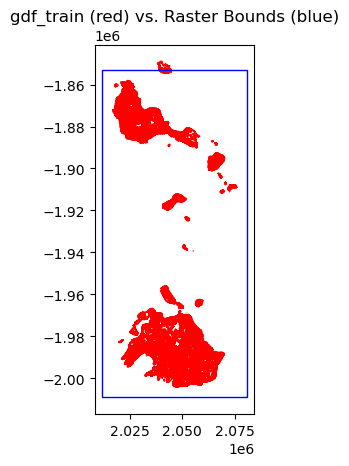

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
gdf_train_clipped.plot(ax=ax, facecolor="none", edgecolor="red")
bbox = box(*s2_clipped_train.rio.bounds())
gpd.GeoSeries([bbox], crs=s2_clipped_train.rio.crs).plot(ax=ax, facecolor="none", edgecolor="blue")
plt.title("gdf_train (red) vs. Raster Bounds (blue)")
plt.show()


In [21]:
gdf_test.lulc_2018_numeric.unique()

array([ 6,  4,  1, 12,  2, 11,  3,  9,  8,  5,  7, 14, 10, 13])

In [22]:
np.unique(rasterized_labels_train['lulc_2018_numeric'].values)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., nan])

In [23]:
# The rasterized output is an xarray.Dataset
rasterized_labels_train = rasterized_labels_train.where(~np.isnan(rasterized_labels_train), other=0).astype(int)  # Replace NaNs with 0
rasterized_labels_test = rasterized_labels_test.where(~np.isnan(rasterized_labels_test), other=0).astype(int)  # Replace NaNs with 0
#rasterized_labels = rasterized_labels.astype(int)
features_train = index_data_train.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable")
features_test = index_data_test.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable")
print("features: ", features_train)
labels_train = rasterized_labels_train.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable").squeeze()
labels_test = rasterized_labels_test.to_array().stack(flattened_pixel=("y", "x")).transpose("flattened_pixel", "variable").squeeze()
print("labels: ", labels_train)

features:  <xarray.DataArray (flattened_pixel: 26978428, variable: 4)> Size: 863MB
dask.array<transpose, shape=(26978428, 4), dtype=float64, chunksize=(719056, 1), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref      int64 8B 0
  * variable         (variable) object 32B 'NDVI' 'MNDWI' 'SAVI' 'BSI'
  * flattened_pixel  (flattened_pixel) object 216MB MultiIndex
  * y                (flattened_pixel) float64 216MB -1.853e+06 ... -2.009e+06
  * x                (flattened_pixel) float64 216MB 2.012e+06 ... 2.081e+06
labels:  <xarray.DataArray (flattened_pixel: 26978428)> Size: 216MB
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
    spatial_ref      int64 8B 0
    variable         <U17 68B 'lulc_2018_numeric'
  * flattened_pixel  (flattened_pixel) object 216MB MultiIndex
  * y                (flattened_pixel) float64 216MB -1.853e+06 ... -2.009e+06
  * x                (flattened_pixel) float64 216MB 2.012e+06 ... 2.081e+06


In [24]:
len(features_train), len(labels_train), len(features_test), len(labels_test)

(26978428, 26978428, 76559784, 76559784)

In [25]:
features_train

<xarray.DataArray (flattened_pixel: 26978428, variable: 4)> Size: 863MB
dask.array<transpose, shape=(26978428, 4), dtype=float64, chunksize=(719056, 1), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref      int64 8B 0
  * variable         (variable) object 32B 'NDVI' 'MNDWI' 'SAVI' 'BSI'
  * flattened_pixel  (flattened_pixel) object 216MB MultiIndex
  * y                (flattened_pixel) float64 216MB -1.853e+06 ... -2.009e+06
  * x                (flattened_pixel) float64 216MB 2.012e+06 ... 2.081e+06

In [26]:
#features_flattened = xr.concat(features_, dim="flattened_pixel")
#labels_flattened = xr.concat(labels_, dim="flattened_pixel")

In [27]:
#features_flattened.shape, labels_flattened.shape

In [28]:
features_train.shape, labels_train.shape

((26978428, 4), (26978428,))

## Data Splitting

Now that we have the arrays flattened, we can split the datasets into training and testing partitions. We will reserve 80 percent of the data for training, and 20 percent for testing.

In [29]:
#features_flattened.shape, labels_flattened.shape

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(
#    features_flattened, labels_flattened, test_size=0.2, random_state=42, shuffle=True
#)

In [31]:
X_train, X_test, y_train, y_test = features_train, features_test, labels_train, labels_test

Ensure all labels are in each partition.

In [32]:
np.unique(y_train), np.unique(y_test) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [33]:
len(X_train), len(X_test), len(y_train), len(y_test)

(26978428, 76559784, 26978428, 76559784)

## Random Forest Classification

Now we will set up a small [random forest classifider](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 10 trees. We use a [seed](https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431) (`random_state`) to ensure reproducibility. Calling the `.fit()` method on the classifier will initiate training.

In [34]:
%%time

dtrain = xgb.DMatrix(X_train, label=y_train)
params = {
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "objective": "multi:softmax",  # or "binary:logistic"
    "num_class": len(np.unique(y_train)),
}

bst = xgb.train(params, dtrain, num_boost_round=100)

CPU times: user 1min 36s, sys: 47.3 s, total: 2min 24s
Wall time: 1min 23s


In [ ]:
#%%time
# Train a Random Forest classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) #n_estimators=10
#clf.fit(X_train, y_train)

## Prediction

Once the classifier is finished training, we can use it to make predictions on our test dataset.

In [35]:
# Create a DMatrix from test features
dtest = xgb.DMatrix(X_test)

# Predict labels
y_pred = bst.predict(dtest)

In [ ]:
# Test the classifier
#y_pred = clf.predict(X_test)

## Evaluation

It's important to know how well our classifier performs relative to the true labels (`y_test`). For this, we can calculate the [accuracy metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to measure agreement between the true and predicted labels.

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9859


In [ ]:
# Evaluate the performance (you can use metrics like accuracy, F1-score, etc.)
#print("Accuracy:", accuracy_score(y_test, y_pred)) #0.60 # 0.6130508977954351 for 50

We can also plot a confusion matrix to explore per-class performance.

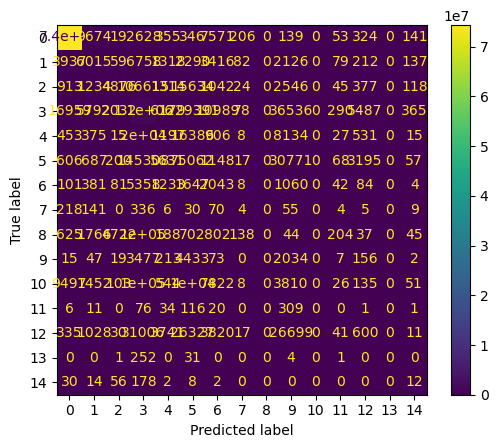

In [37]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

Notice that we see a high variability in the performance across classes. This is likely due to a class imbalance or inter-class differentiation challenge within our training dataset. It's possible that augmentations or class revision may help to address this.

## Visualization

If we want to generate predictions for the entire dataset in order to plot a map of predicted LULC for the entire area of interest, we can do this using the full (un-partitioned) features dataset.

In [39]:
#y_pred_full = clf.predict(features_test)
#predicted_map = y_pred_full.reshape((height_test, width_test))
predicted_map = y_pred.reshape((height_test, width_test))
predicted_map_xr = xr.DataArray(data=predicted_map, coords=rasterized_labels_test.coords)
print(np.unique(y_pred))
    

[ 0.  1.  2.  3.  4.  5.  6.  7.  9. 11. 12. 14.]


In [40]:
predicted_map_xr, rasterized_labels_test

(<xarray.DataArray (y: 8518, x: 8988)> Size: 306MB
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 Coordinates:
   * y            (y) float64 68kB -1.453e+06 -1.453e+06 ... -1.624e+06
   * x            (x) float64 72kB 1.837e+06 1.837e+06 ... 2.016e+06 2.016e+06
     spatial_ref  int64 8B 0,
 <xarray.Dataset> Size: 613MB
 Dimensions:            (y: 8518, x: 8988)
 Coordinates:
   * y                  (y) float64 68kB -1.453e+06 -1.453e+06 ... -1.624e+06
   * x                  (x) float64 72kB 1.837e+06 1.837e+06 ... 2.016e+06
     spatial_ref        int64 8B 0
 Data variables:
     lulc_2018_numeric  (y, x) int64 612MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0)

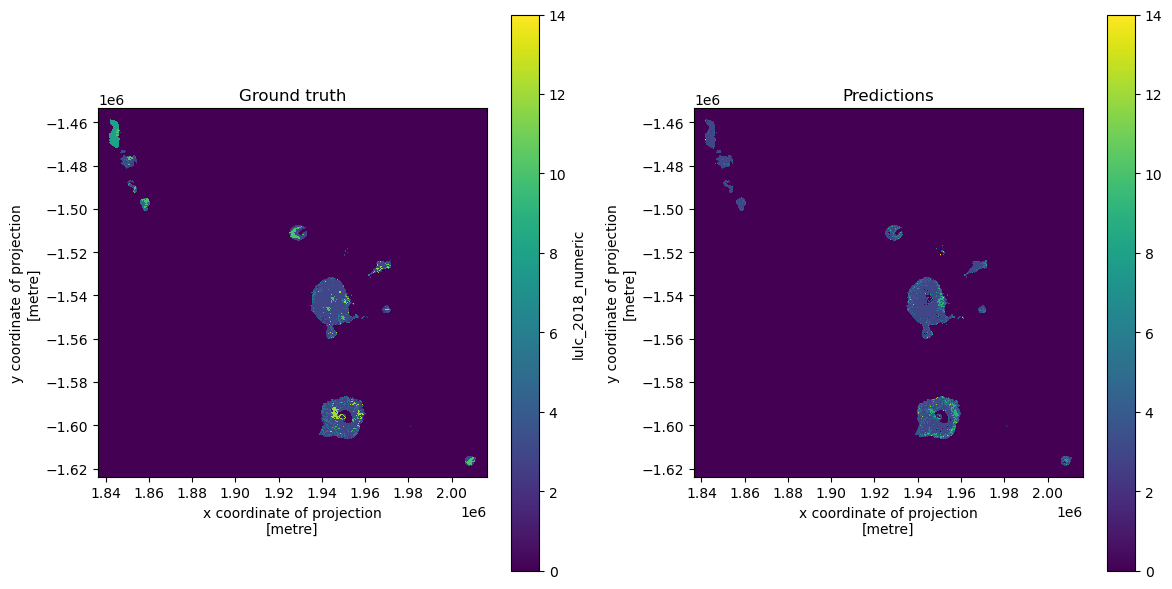

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

rasterized_labels_test["lulc_2018_numeric"].plot(ax=axes[0], cmap="viridis")
axes[0].set_title("Ground truth")
axes[0].set_aspect('equal')

predicted_map_xr.plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Predictions")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [42]:
compatible_array = predicted_map_xr.astype("int32")

# Rasterize to polygons
polygons = list(
    rasterio.features.shapes(compatible_array.values, transform=compatible_array.rio.transform())
)

# Convert polygons to GeoDataFrame
prediction_gdf = gpd.GeoDataFrame(
    [{"geometry": shape(geom), "value": value} for geom, value in polygons],
    crs="EPSG:4326",
)
#print(prediction_gdf)
print(prediction_gdf.value.unique())

prediction_gdf.to_file(f"./predicted_lulc_utm_{PROVINCE_TEST}_{YEAR}.geojson", driver="GeoJSON")

[ 6.  1. 12. 11.  3.  7.  4.  0.  5.  9.  2. 14.]
